In [1]:
import sys
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
import numpy as np
from keras.applications import VGG16    
import pandas as pd
import glob
import imp
import skimage as sk
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten,LeakyReLU
from keras.models import Model
import scipy
from skimage import exposure, color
from scipy.stats import wilcoxon
from sklearn.model_selection import train_test_split
from sklearn import metrics
import collections
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import cross_val_score, StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from matplotlib.pyplot import figure, show
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
import matplotlib.style as style
style.available
import missingno as msno

In [2]:
!curl -L -O https://www.dropbox.com/s/rw85nzu2vq1k9j1/diabetes.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 23873  100 23873    0     0  22415      0  0:00:01  0:00:01 --:--:-- 22415


In [0]:
data = pd.read_csv("diabetes.csv") 

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print("Number of features: ", data.shape[1])
print("Number of samples: ", data.shape[0])

Number of features:  9
Number of samples:  768


#Background

##What is diabetes?


---


"Diabetes is a disease that occurs when your blood glucose, also called blood sugar, is too high. Blood glucose is your main source of energy and comes from the food you eat. Insulin, a hormone made by the pancreas, helps glucose from food get into your cells to be used for energy."

*   **Type 1:** If you have type 1 diabetes, your body does not make insulin. Your immune system attacks and destroys the cells in your pancreas that make insulin. Type 1 diabetes is usually diagnosed in children and young adults, although it can appear at any age. People with type 1 diabetes need to take insulin every day to stay alive.
*   **Type 2:** If you have type 2 diabetes, your body does not make or use insulin well. You can develop type 2 diabetes at any age, even during childhood. However, this type of diabetes occurs most often in middle-aged and older people. Type 2 is the most common type of diabetes.
*   **Gestational diabetes:** Gestational diabetes develops in some women when they are pregnant. Most of the time, this type of diabetes goes away after the baby is born. However, if you’ve had gestational diabetes, you have a greater chance of developing type 2 diabetes later in life. Sometimes diabetes diagnosed during pregnancy is actually type 2 diabetes.

[Reference link](https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes)


##Dataset

This dataset is originally from the **National Institute of Diabetes and Digestive and Kidney Diseases**. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

##Features
· **Pregnancies**: Number of times pregnant.

· **Glucose**: Plasma glucose concentration over 2 hours in an oral glucose tolerance test.

· **BloodPressure**: Diastolic blood pressure (mm Hg).

· **SkinThickness**: Triceps skin fold thickness (mm).

· **Insulin**: 2-Hour serum insulin (mu U/ml).

· **BMI**: Body mass index (weight in kg/(height in m)2).

· **DiabetesPedigreeFunction**: iabetes pedigree function (a function which scores likelihood of diabetes based on family history).

· **Age**: No explanation needed.

##Objective
Our purpose is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.

# Handling missing data

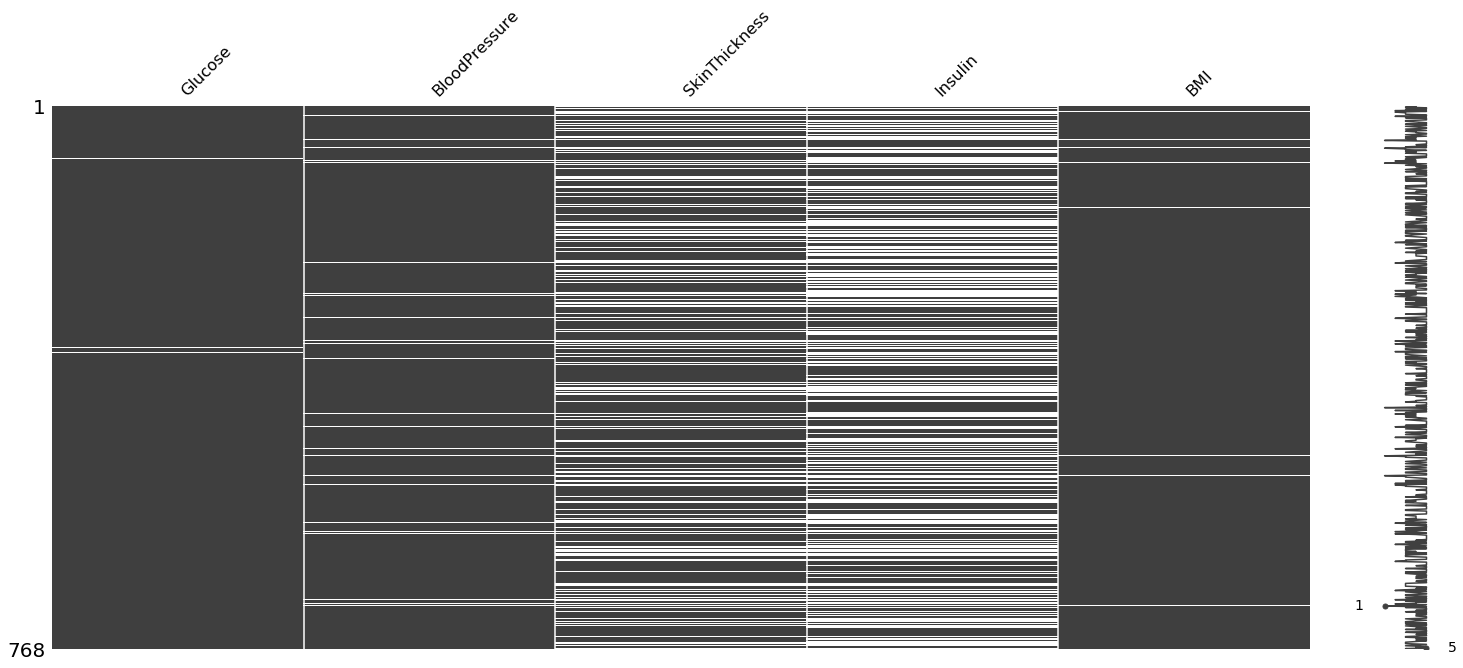

In [6]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]= data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)
msno.matrix(data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])

We replace the missing values with the mean.

In [0]:
data = data.fillna(data.mean())

In [8]:
data.loc[data['Outcome']==1].mean()

Pregnancies                   4.865672
Glucose                     142.165573
BloodPressure                75.147324
SkinThickness                31.736944
Insulin                     180.431548
BMI                          35.384757
DiabetesPedigreeFunction      0.550500
Age                          37.067164
Outcome                       1.000000
dtype: float64

In [9]:
data.loc[data['Outcome']==0].mean()

Pregnancies                   3.298000
Glucose                     110.710121
BloodPressure                70.935397
SkinThickness                27.768651
Insulin                     142.210761
BMI                          30.888434
DiabetesPedigreeFunction      0.429734
Age                          31.190000
Outcome                       0.000000
dtype: float64

#Visualizing data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fc3efea20>],
      dtype=object)

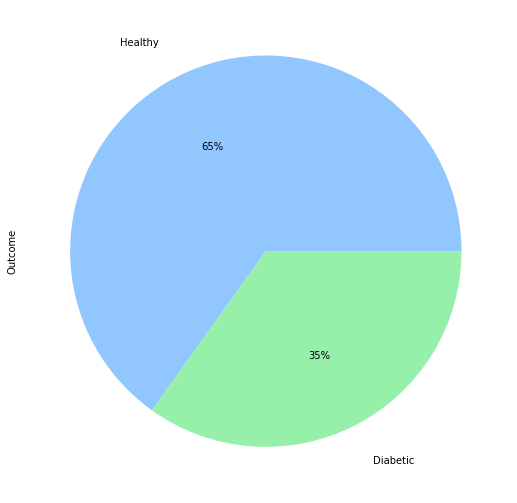

In [10]:
style.use('seaborn-pastel')
labels = ["Healthy", "Diabetic"]
data['Outcome'].value_counts().plot(kind='pie',labels=labels, subplots=True,autopct='%1.0f%%', labeldistance=1.2, figsize=(9,9))

Samples of diabetic people:  268
Samples of healthy people:  500


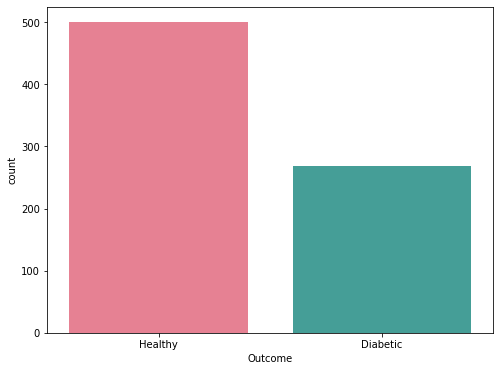

In [11]:
figure(figsize=(8,6))
ax = sns.countplot(x=data['Outcome'], data=data,palette="husl")
ax.set_xticklabels(["Healthy","Diabetic"])
healthy, diabetics = data['Outcome'].value_counts().values
print("Samples of diabetic people: ", diabetics)
print("Samples of healthy people: ", healthy)

# Correlation between the data

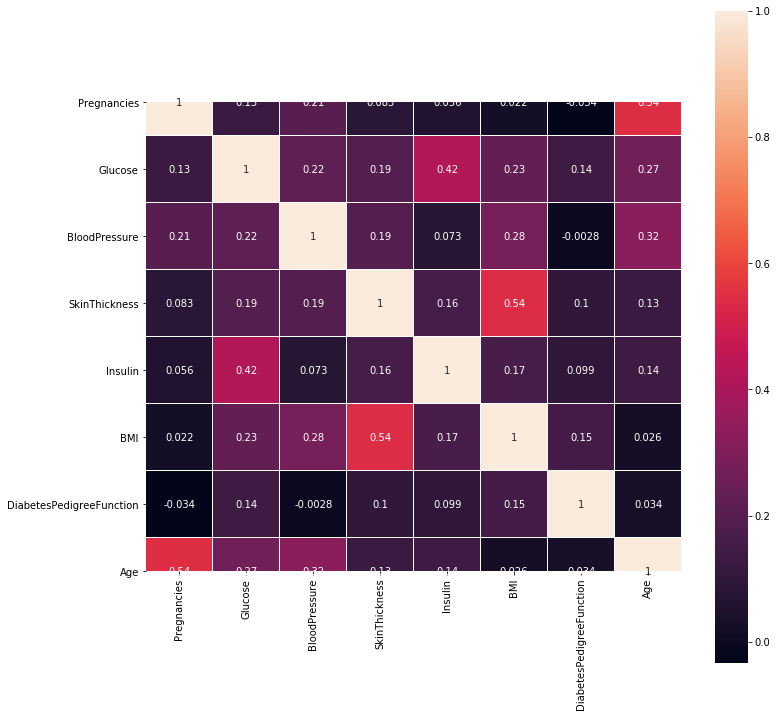

In [13]:
plt.figure(figsize = (12,12))
corr = data.iloc[:,0:8].corr()
ax = sns.heatmap(corr, square=True,linewidths=0.01,annot=True)

# Distributions

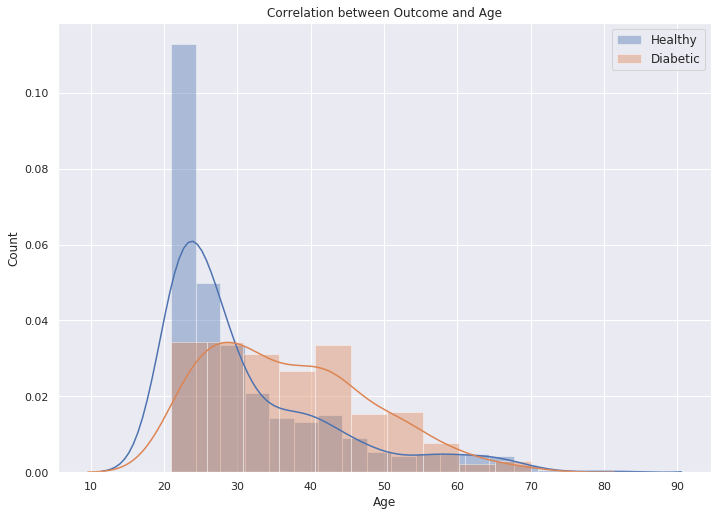

In [15]:
sns.distplot(data.loc[data['Outcome']==0, 'Age'],label='Healthy')
sns.distplot(data.loc[data['Outcome']==1, 'Age'], hist_kws=dict(alpha=0.4), label='Diabetic')
plt.legend(prop={'size': 12})
plt.title('Correlation between Outcome and Age')
plt.xlabel('Age')
plt.ylabel('Count')  
sns.set(rc={'figure.figsize':(11.7,8.27)})



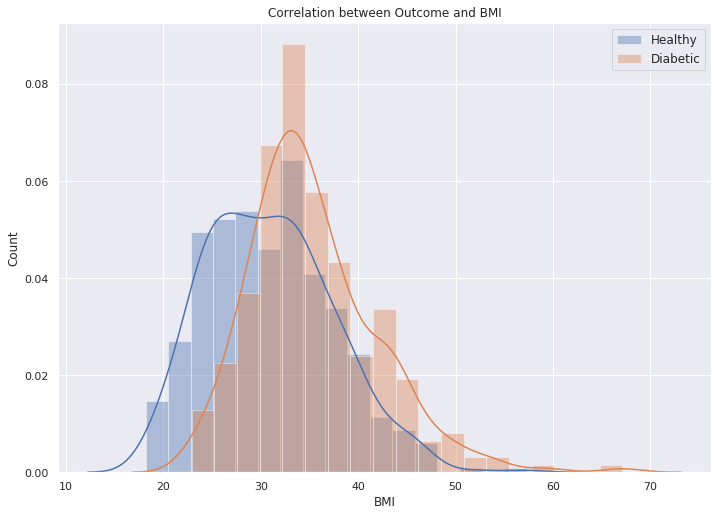

In [16]:
sns.distplot(data.loc[data['Outcome']==0, 'BMI'],label='Healthy')
sns.distplot(data.loc[data['Outcome']==1, 'BMI'], hist_kws=dict(alpha=0.4), label='Diabetic')
plt.legend(prop={'size': 12})
plt.title('Correlation between Outcome and BMI')
plt.xlabel('BMI')
plt.ylabel('Count')  
sns.set(rc={'figure.figsize':(11.7,8.27)})


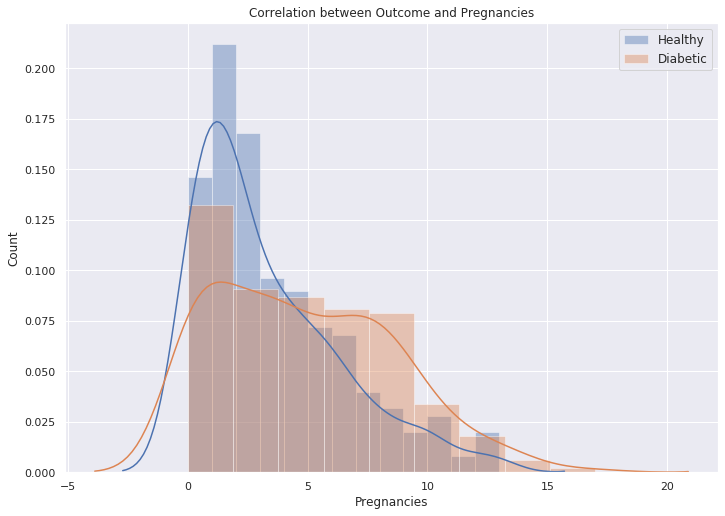

In [17]:
sns.distplot(data.loc[data['Outcome']==0, 'Pregnancies'],label='Healthy')
sns.distplot(data.loc[data['Outcome']==1, 'Pregnancies'], hist_kws=dict(alpha=0.4), label='Diabetic')
plt.legend(prop={'size': 12})
plt.title('Correlation between Outcome and Pregnancies')
plt.xlabel('Pregnancies')
plt.ylabel('Count')  
sns.set(rc={'figure.figsize':(11.7,8.27)})



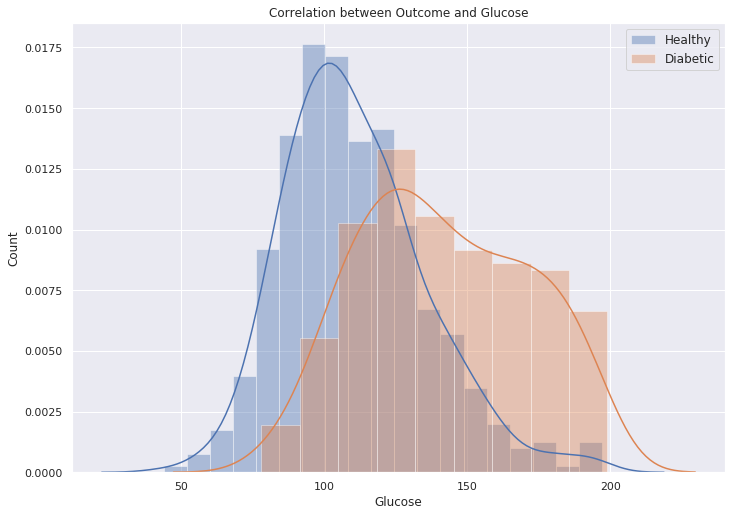

In [18]:
sns.distplot(data.loc[data['Outcome']==0, 'Glucose'],label='Healthy')
sns.distplot(data.loc[data['Outcome']==1, 'Glucose'], hist_kws=dict(alpha=0.4), label='Diabetic')
plt.legend(prop={'size': 12})
plt.title('Correlation between Outcome and Glucose')
plt.xlabel('Glucose')
plt.ylabel('Count')  
sns.set(rc={'figure.figsize':(11.7,8.27)})


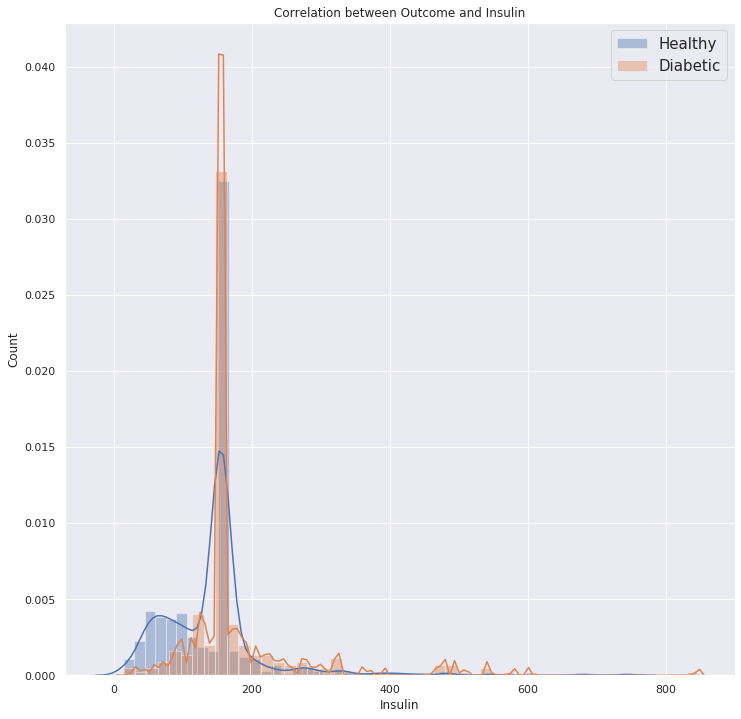

In [22]:
sns.distplot(data.loc[data['Outcome']==0, 'Insulin'],label='Healthy')
sns.distplot(data.loc[data['Outcome']==1, 'Insulin'], hist_kws=dict(alpha=0.4), label='Diabetic')
plt.legend(prop={'size': 15})
plt.title('Correlation between Outcome and Insulin')
plt.xlabel('Insulin')
plt.ylabel('Count')  
sns.set(rc={'figure.figsize':(14,12)})



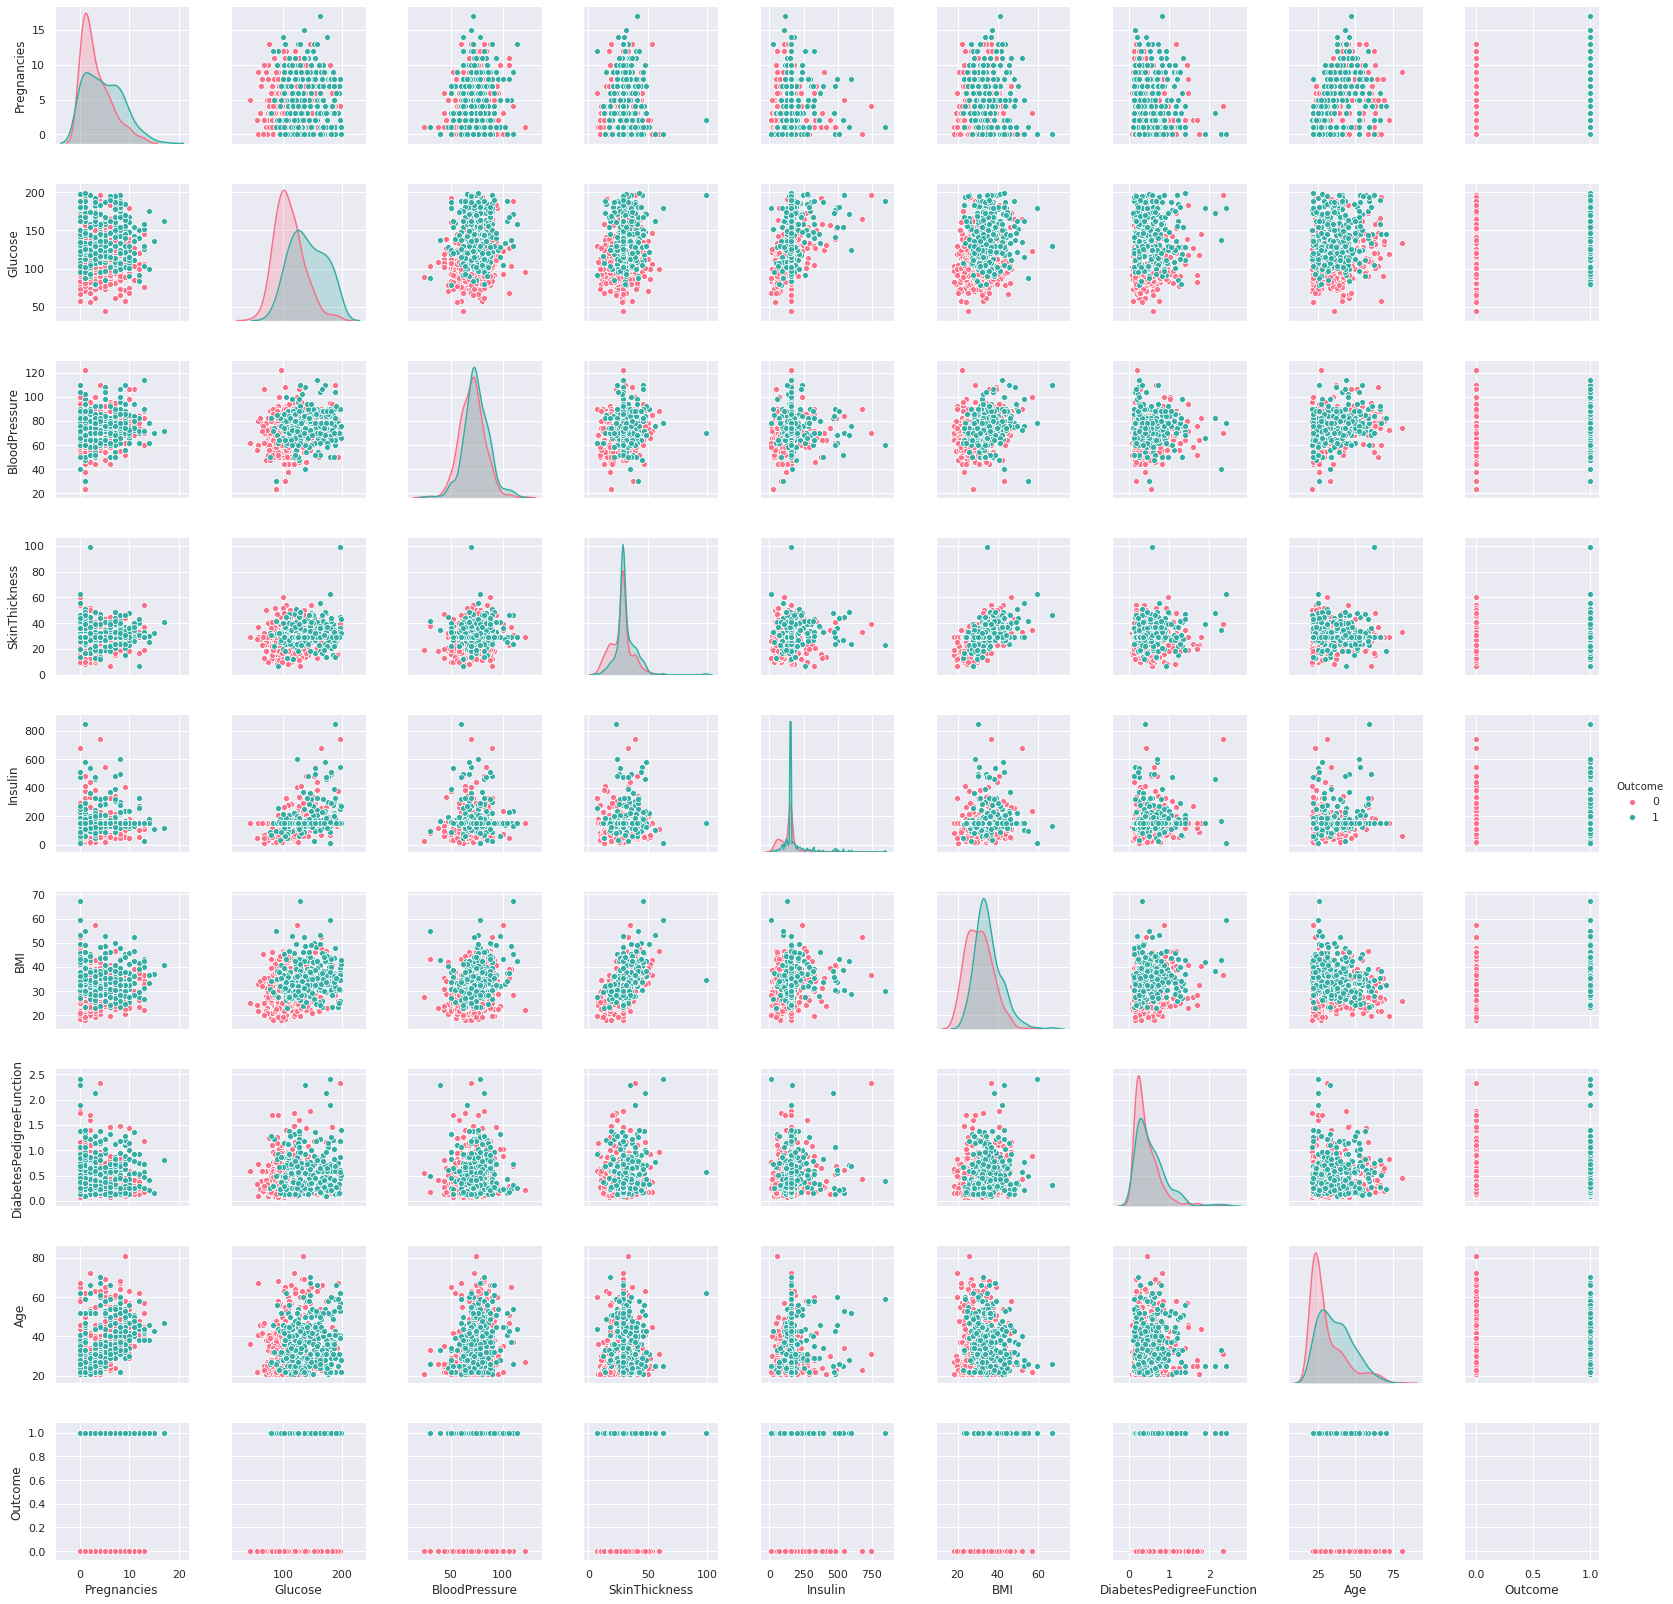

In [23]:
g = sns.pairplot(data, hue="Outcome",palette="husl")

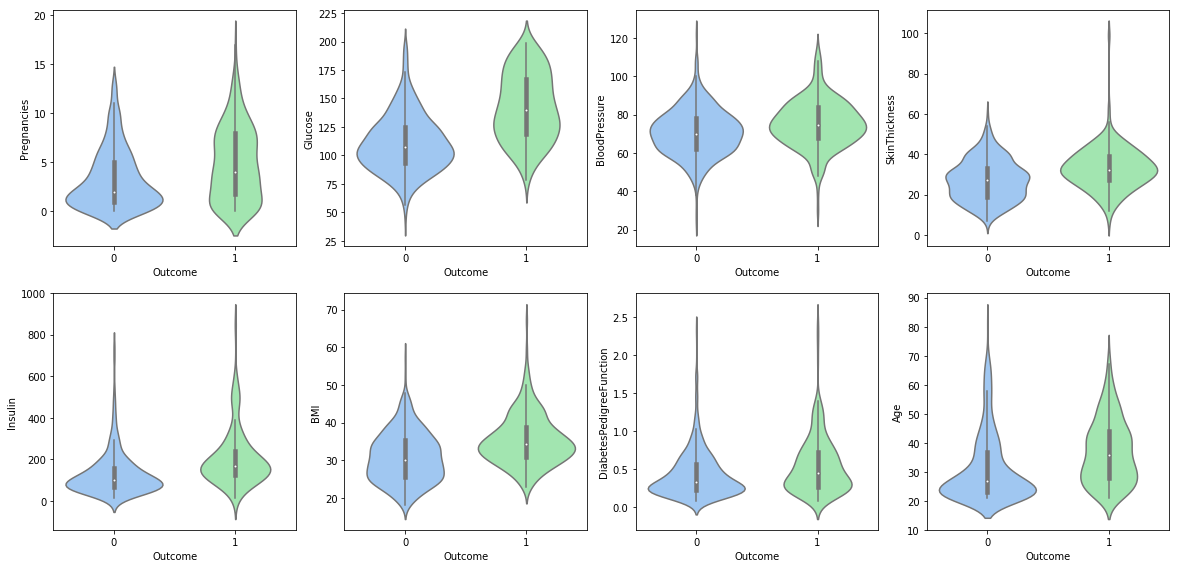

In [0]:
plt.figure(figsize=(20, 20))

for column_index, column in enumerate(data.columns):
    if column == 'Outcome':
        continue
    plt.subplot(4, 4, column_index + 1)
    sns.violinplot(x='Outcome', y=column, data=data)
